

Set up Pyspark

In [ ]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 46 kB/s 
     |████████████████████████████████| 199 kB 54.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=ebcd73a351429637a5544adc553a97a962dc47593496477f41bd2726381d5311
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import pyspark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
spark

Import additional libraries

In [ ]:
!pip install pandas_bokeh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyspark.pandas as ps
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_bokeh import *

In [ ]:
df = spark.read.csv('/content/adult.csv', header=True, inferSchema=True)

3. Display top 10 rows of the dataset.

In [ ]:
df.show(10)

+---+----------------+------+------------+---------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|   education|educational-num|    marital-status|       occupation| relationship| race|gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+----------------+------+------------+---------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
| 25|         Private|226802|        11th|              7|     Never-married|Machine-op-inspct|    Own-child|Black|  Male|           0|           0|            40| United-States| <=50K|
| 38|         Private| 89814|     HS-grad|              9|Married-civ-spouse|  Farming-fishing|      Husband|White|  Male|           0|           0|            50| United-States| <=50K|
| 28|       Local-gov|336951|  Assoc-acdm|             12|Married-civ-

4. Check last 10 rows of the dataset.

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import desc
 
df = df.withColumn("index", monotonically_increasing_id())
df.orderBy(desc("index")).drop("index").show(10)

+---+------------+------+------------+---------------+------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+
|age|   workclass|fnlwgt|   education|educational-num|    marital-status|       occupation| relationship|              race|gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+------------+------+------------+---------------+------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+
| 52|Self-emp-inc|287927|     HS-grad|              9|Married-civ-spouse|  Exec-managerial|         Wife|             White|Female|       15024|           0|            40| United-States|  >50K|
| 22|     Private|201490|     HS-grad|              9|     Never-married|     Adm-clerical|    Own-child|             White|  Male|           0|           0|            20| United-States| <=50K|
| 58|     Private|151910|

5. Find shape of dataset (number of rows and number of columns).

In [ ]:
print("Total number of rows: ", df.count())
print("Total number of columns: ", len(df.columns) -1)

Total number of rows:  48842
Total number of columns:  15


Data Cleaning

In [ ]:
df

DataFrame[age: int, workclass: string, fnlwgt: int, education: string, educational-num: int, marital-status: string, occupation: string, relationship: string, race: string, gender: string, capital-gain: int, capital-loss: int, hours-per-week: int, native-country: string, income: string, index: bigint]

All data types look correct

In [ ]:
df = df.withColumnRenamed(existing="fnlwgt", new="final-weight")
df = df.withColumnRenamed(existing="educational-num", new="educationalnum")
df = df.withColumnRenamed(existing="marital-status", new="maritalstatus")
df = df.withColumnRenamed(existing="capital-gain", new="capitalgain")
df = df.withColumnRenamed(existing="capital-loss", new="capitalloss")
df = df.withColumnRenamed(existing="hours-per-week", new="hoursperweek")
df = df.withColumnRenamed(existing="native-country", new="nativecountry")
df.show()

+---+----------------+------------+------------+--------------+------------------+-----------------+-------------+------------------+------+-----------+-----------+------------+-------------+------+-----+
|age|       workclass|final-weight|   education|educationalnum|     maritalstatus|       occupation| relationship|              race|gender|capitalgain|capitalloss|hoursperweek|nativecountry|income|index|
+---+----------------+------------+------------+--------------+------------------+-----------------+-------------+------------------+------+-----------+-----------+------------+-------------+------+-----+
| 25|         Private|      226802|        11th|             7|     Never-married|Machine-op-inspct|    Own-child|             Black|  Male|          0|          0|          40|United-States| <=50K|    0|
| 38|         Private|       89814|     HS-grad|             9|Married-civ-spouse|  Farming-fishing|      Husband|             White|  Male|          0|          0|          50|Uni

In [ ]:
#check for duplicates rows using pyspark(not pyspark.pandas)

from pyspark.sql import functions as F

cols = df.columns

counts_df = df.select([
    F.countDistinct(*cols).alias('n_unique'),
    F.count('*').alias('n_rows')
])
n_unique, n_rows = counts_df.collect()[0]
print(n_unique)
print(n_rows)

48842
48842


No duplicates

In [ ]:
### Get count of null values in pyspark
 
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---------+------------+---------+--------------+-------------+----------+------------+----+------+-----------+-----------+------------+-------------+------+-----+
|age|workclass|final-weight|education|educationalnum|maritalstatus|occupation|relationship|race|gender|capitalgain|capitalloss|hoursperweek|nativecountry|income|index|
+---+---------+------------+---------+--------------+-------------+----------+------------+----+------+-----------+-----------+------------+-------------+------+-----+
|  0|        0|           0|        0|             0|            0|         0|           0|   0|     0|          0|          0|           0|            0|     0|    0|
+---+---------+------------+---------+--------------+-------------+----------+------------+----+------+-----------+-----------+------------+-------------+------+-----+



In [ ]:
#count the number of question marks in each column in dataset
df.select([count(when(col(c) == '?', c)).alias(c) for c in df.columns]).show()

+---+---------+------------+---------+--------------+-------------+----------+------------+----+------+-----------+-----------+------------+-------------+------+-----+
|age|workclass|final-weight|education|educationalnum|maritalstatus|occupation|relationship|race|gender|capitalgain|capitalloss|hoursperweek|nativecountry|income|index|
+---+---------+------------+---------+--------------+-------------+----------+------------+----+------+-----------+-----------+------------+-------------+------+-----+
|  0|     2799|           0|        0|             0|            0|      2809|           0|   0|     0|          0|          0|           0|          857|     0|    0|
+---+---------+------------+---------+--------------+-------------+----------+------------+----+------+-----------+-----------+------------+-------------+------+-----+



In [ ]:
from pyspark.sql.functions import when
df = df.withColumn("workclass", when(df.workclass == "?","Unknown workClass").otherwise(df.workclass))
df = df.withColumn("occupation", when(df.occupation == "?","Unknown Occupation").otherwise(df.occupation))
df = df.withColumn("nativecountry", when(df.nativecountry == "?","Unknown Country").otherwise(df.nativecountry))
df = df.withColumn("income_0_1", when(df.income == "<=50K", 0).otherwise(1))

In [ ]:
df.show(50)

+---+-----------------+------------+------------+--------------+------------------+------------------+-------------+------------------+------+-----------+-----------+------------+---------------+------+-----+----------+
|age|        workclass|final-weight|   education|educationalnum|     maritalstatus|        occupation| relationship|              race|gender|capitalgain|capitalloss|hoursperweek|  nativecountry|income|index|income_0_1|
+---+-----------------+------------+------------+--------------+------------------+------------------+-------------+------------------+------+-----------+-----------+------------+---------------+------+-----+----------+
| 25|          Private|      226802|        11th|             7|     Never-married| Machine-op-inspct|    Own-child|             Black|  Male|          0|          0|          40|  United-States| <=50K|    0|         0|
| 38|          Private|       89814|     HS-grad|             9|Married-civ-spouse|   Farming-fishing|      Husband|    

In [ ]:
#confirm the number of question marks in each column in dataset
df.select([count(when(col(c) == '?', c)).alias(c) for c in df.columns]).show()

+---+---------+------------+---------+--------------+-------------+----------+------------+----+------+-----------+-----------+------------+-------------+------+-----+----------+
|age|workclass|final-weight|education|educationalnum|maritalstatus|occupation|relationship|race|gender|capitalgain|capitalloss|hoursperweek|nativecountry|income|index|income_0_1|
+---+---------+------------+---------+--------------+-------------+----------+------------+----+------+-----------+-----------+------------+-------------+------+-----+----------+
|  0|        0|           0|        0|             0|            0|         0|           0|   0|     0|          0|          0|           0|            0|     0|    0|         0|
+---+---------+------------+---------+--------------+-------------+----------+------------+----+------+-----------+-----------+------------+-------------+------+-----+----------+



In [ ]:
df.drop(df.index) \
  .printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- final-weight: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educationalnum: integer (nullable = true)
 |-- maritalstatus: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capitalgain: integer (nullable = true)
 |-- capitalloss: integer (nullable = true)
 |-- hoursperweek: integer (nullable = true)
 |-- nativecountry: string (nullable = true)
 |-- income: string (nullable = true)
 |-- income_0_1: integer (nullable = false)



Done Cleaning

6. Getting information about dataset like total number rows, total number of
columns, datatypes of each column and memory requirement.

In [ ]:
df.describe().show()

+-------+------------------+-----------+------------------+------------+------------------+-------------+------------------+------------+------------------+------+------------------+-----------------+------------------+-------------+------+--------------------+-------------------+
|summary|               age|  workclass|      final-weight|   education|    educationalnum|maritalstatus|        occupation|relationship|              race|gender|       capitalgain|      capitalloss|      hoursperweek|nativecountry|income|               index|         income_0_1|
+-------+------------------+-----------+------------------+------------+------------------+-------------+------------------+------------+------------------+------+------------------+-----------------+------------------+-------------+------+--------------------+-------------------+
|  count|             48842|      48842|             48842|       48842|             48842|        48842|             48842|       48842|             4884

Convert Pyspark dataframe to Pandas Dataframe

In [ ]:
pdf = ps.DataFrame(df)

In [ ]:
pdf.head()

,age,workclass,final-weight,education,educationalnum,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,income,index,income_0_1
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,1,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,2,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,3,1
4,18,Unknown workClass,103497,Some-college,10,Never-married,Unknown Occupation,Own-child,White,Female,0,0,30,United-States,<=50K,4,0


In [ ]:
print("Percentage of duplicated data/rows within dataset: ", pdf.duplicated().sum() * 100 / len(pdf))

Percentage of duplicated data/rows within dataset:  0.0


In [ ]:
print("Percentage of Missing data within dataset: ", pdf.isnull().sum() * 100 / len(pdf))

Percentage of Missing data within dataset:  age               0.0
workclass         0.0
final-weight      0.0
education         0.0
educationalnum    0.0
maritalstatus     0.0
occupation        0.0
relationship      0.0
race              0.0
gender            0.0
capitalgain       0.0
capitalloss       0.0
hoursperweek      0.0
nativecountry     0.0
income            0.0
index             0.0
income_0_1        0.0
dtype: float64


In [ ]:
pdf.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 48841
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int32 
 1   workclass       48842 non-null  object
 2   final-weight    48842 non-null  int32 
 3   education       48842 non-null  object
 4   educationalnum  48842 non-null  int32 
 5   maritalstatus   48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   gender          48842 non-null  object
 10  capitalgain     48842 non-null  int32 
 11  capitalloss     48842 non-null  int32 
 12  hoursperweek    48842 non-null  int32 
 13  nativecountry   48842 non-null  object
 14  income          48842 non-null  object
 15  index           48842 non-null  int64 
 16  income_0_1      48842 non-null  int32 
dtypes: int32(7), int64(1), object(9)

7. Fetch random sample from the dataset (50%).

In [ ]:
# Randomly sample 50% of your dataframe, using pyspark-pandas module
df_50_percent = pdf.sample(frac=0.5)
df_50_percent.head()

,age,workclass,final-weight,education,educationalnum,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,income,index,income_0_1
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,1,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,2,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,3,1
4,18,Unknown workClass,103497,Some-college,10,Never-married,Unknown Occupation,Own-child,White,Female,0,0,30,United-States,<=50K,4,0


1. Get overall statistics about the dataframe
a. Try to describe the data
b. Try to describe categorical as well as numerical data
c. Show unique values of ‘education’ column
d. Show unique values of ‘educational-num’ column

In [ ]:
pdf.corr()

,age,final-weight,educationalnum,capitalgain,capitalloss,hoursperweek,index,income_0_1
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558,-0.004967,0.230369
final-weight,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519,0.002579,-0.006339
educationalnum,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689,-0.004294,0.332613
capitalgain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157,-0.004300,0.223013
capitalloss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467,0.000864,0.147554
hoursperweek,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000,0.004985,0.227687
index,-0.004967,0.002579,-0.004294,-0.004300,0.000864,0.004985,1.000000,0.005234
income_0_1,0.230369,-0.006339,0.332613,0.223013,0.147554,0.227687,0.005234,1.000000


In [ ]:
education_count_df = pdf.groupby('education').count().reset_index()
education_count_df2 = education_count_df[['education', 'age']].sort_values(by='age', ascending=False).reset_index()
education_count_df2

,index,education,age
0,7,HS-grad,15784
1,14,Some-college,10878
2,8,Bachelors,8025
3,1,Masters,2657
4,4,Assoc-voc,2061
5,9,11th,1812
6,3,Assoc-acdm,1601
7,0,10th,1389
8,5,7th-8th,955
9,15,Prof-school,834


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/indexing.py:1362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


[Text(0.5, 1.0, 'Count of Education Levels')]

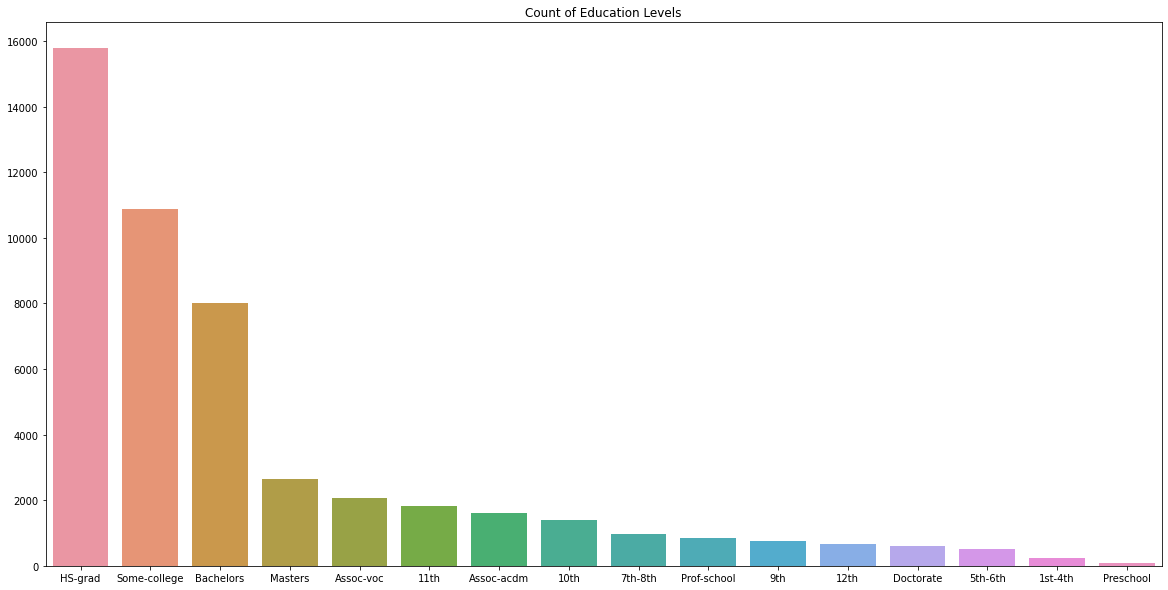

In [ ]:
education_count_df2['age'] = education_count_df2['age'].astype(int)
x = education_count_df2['education'].to_numpy()
y = education_count_df2['age'].to_numpy()
plt.figure(figsize=(20,10))
sns.barplot(x = x, y = y, data = education_count_df2).set(title="Count of Education Levels")

Most have graduated college, Primary School. Very little have not graduated Primary school or attended Graduate. There are 3 times as many bachelores degrees as Masters degrees.

In [ ]:
occupation_count_df = pdf.groupby('occupation').count().reset_index()
occupation_count_df2 = occupation_count_df[['occupation', 'age']].sort_values(by='age', ascending=False).reset_index()
occupation_count_df2

,index,occupation,age
0,2,Prof-specialty,6172
1,5,Craft-repair,6112
2,1,Exec-managerial,6086
3,14,Adm-clerical,5611
4,0,Sales,5504
5,9,Other-service,4923
6,11,Machine-op-inspct,3022
7,13,Unknown Occupation,2809
8,6,Transport-moving,2355
9,3,Handlers-cleaners,2072


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/indexing.py:1362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


[Text(0.5, 1.0, 'Count of Occupations(Lines of Work)')]

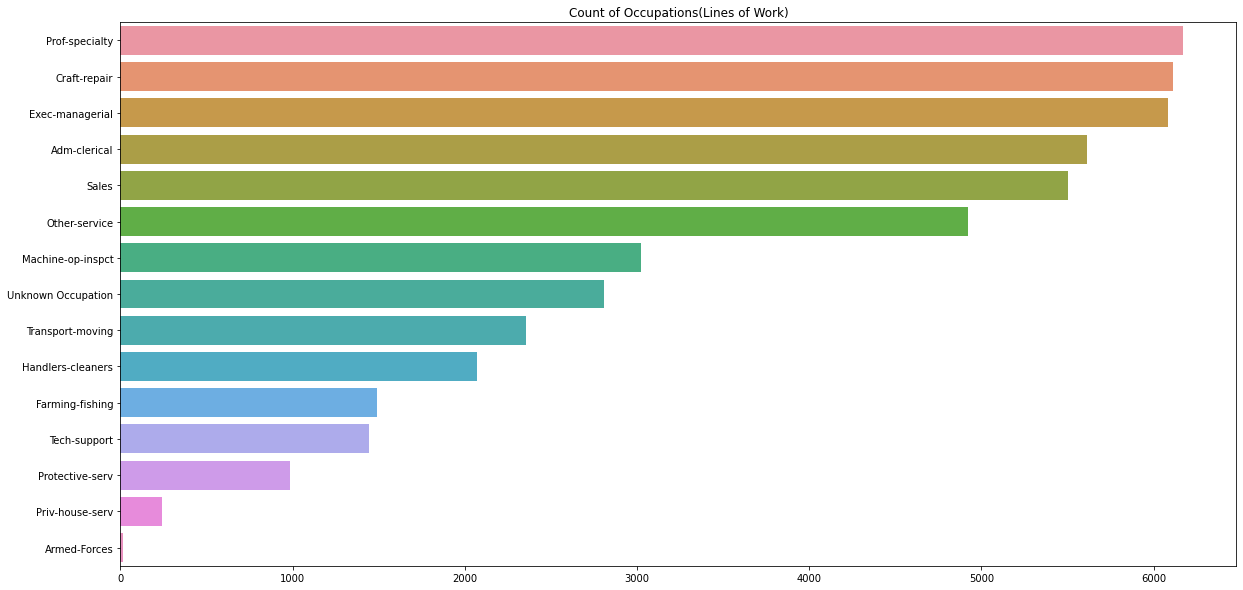

In [ ]:
occupation_count_df2['age'] = occupation_count_df2['age'].astype(int)
x = occupation_count_df2['occupation'].to_numpy()
y = occupation_count_df2['age'].to_numpy()
plt.figure(figsize=(20,10))
sns.barplot(x = y, y = x, data = occupation_count_df2).set(title="Count of Occupations(Lines of Work)")

Very little were in the armedforces. A major majority were in Prof speciality to other services.

In [ ]:
educationalnum_count_df = pdf.groupby('educationalnum').count().reset_index()
educationalnum_count_df2 = educationalnum_count_df[['educationalnum', 'age']].sort_values(by='age', ascending=False).reset_index()
educationalnum_count_df2

,index,educationalnum,age
0,8,9,15784
1,12,10,10878
2,2,13,8025
3,14,14,2657
4,13,11,2061
5,11,7,1812
6,0,12,1601
7,3,6,1389
8,9,4,955
9,7,15,834


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/indexing.py:1362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


[Text(0.5, 1.0, 'Count of Total Years of Education')]

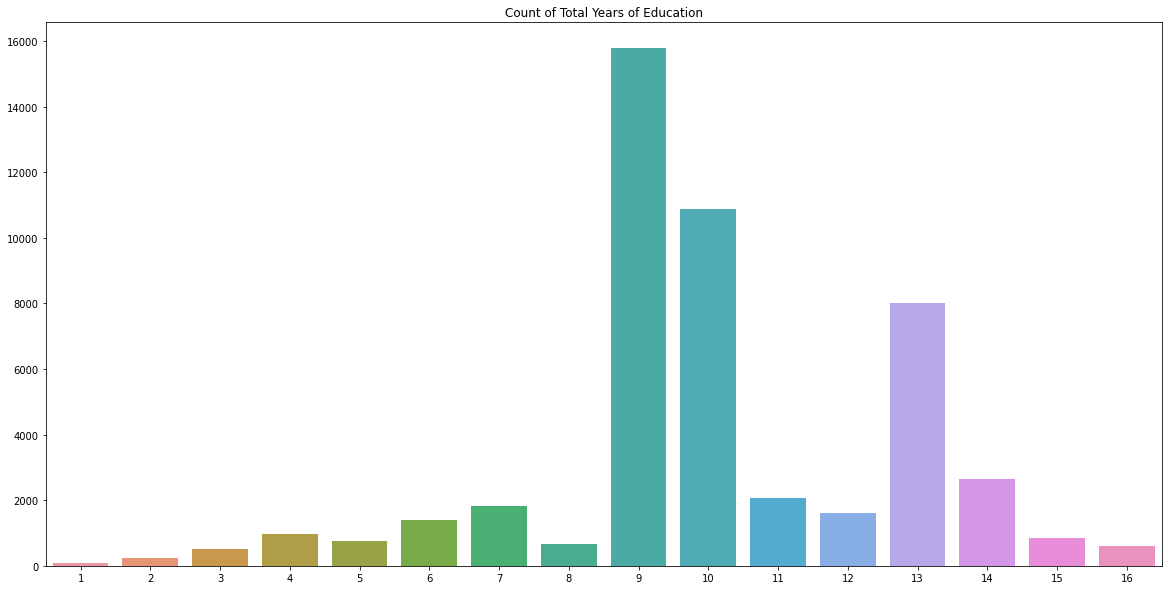

In [ ]:
educationalnum_count_df2['age'] = educationalnum_count_df2['age'].astype(int)
x = educationalnum_count_df2['educationalnum'].to_numpy()
y = educationalnum_count_df2['age'].to_numpy()
plt.figure(figsize=(20,10))
sns.barplot(x = x, y = y, data = educationalnum_count_df2).set(title="Count of Total Years of Education")

If someone had 12 -13 total years of education than they graduated high-school/primary. Anything after that is the college years. 10 -11 years they almost graduated primary school, but still have not completed those required grades.

In [ ]:
relationship_count_df = pdf.groupby('relationship').count().reset_index()
relationship_count_df2 = relationship_count_df[['relationship', 'age']].sort_values(by='age', ascending=False).reset_index()
relationship_count_df2

,index,relationship,age
0,5,Husband,19716
1,1,Not-in-family,12583
2,0,Own-child,7581
3,2,Unmarried,5125
4,3,Wife,2331
5,4,Other-relative,1506


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/indexing.py:1362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


[Text(0.5, 1.0, 'Total Count of Relationship Types(Husband, Wife, etc.)')]

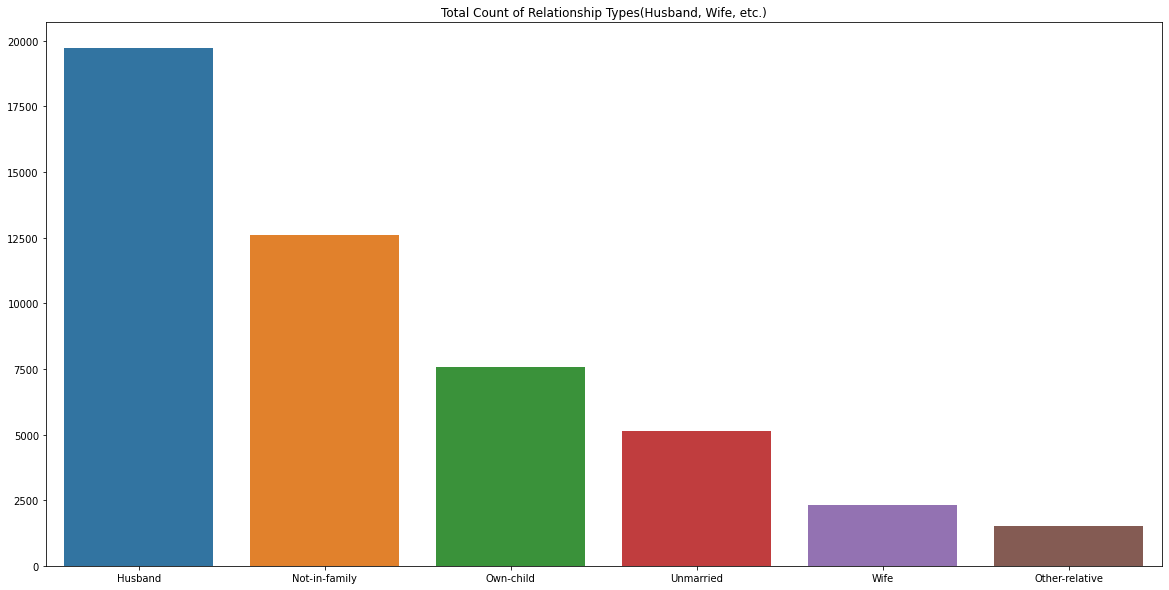

In [ ]:
relationship_count_df2['age'] = relationship_count_df2['age'].astype(int)
x = relationship_count_df2['relationship'].to_numpy()
y = relationship_count_df2['age'].to_numpy()
plt.figure(figsize=(20,10))
sns.barplot(x = x, y = y, data = relationship_count_df2).set(title="Total Count of Relationship Types(Husband, Wife, etc.)")

There are way more husbands than Wives. Are there more men than women in dataset.

In [ ]:
gender_count_df = pdf.groupby('gender').count().reset_index()
gender_count_df2 = gender_count_df[['gender', 'age']].sort_values(by='age', ascending=False).reset_index()
gender_count_df2

,index,gender,age
0,1,Male,32650
1,0,Female,16192


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/indexing.py:1362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


[Text(0.5, 1.0, 'Number of Males/Females')]

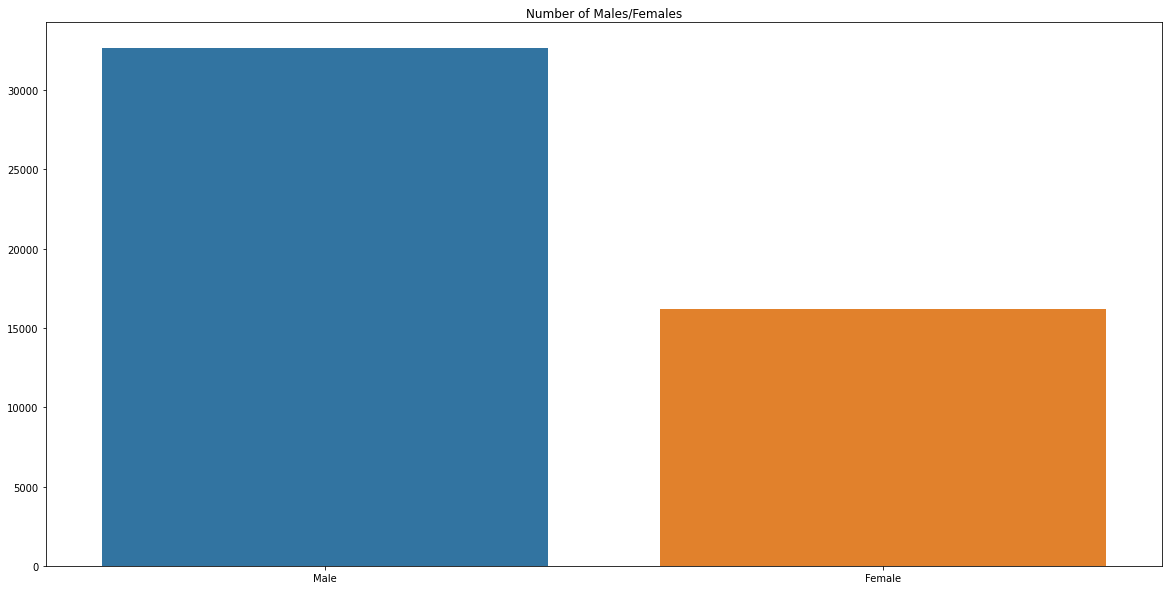

In [ ]:
gender_count_df2['age'] = gender_count_df2['age'].astype(int)
x = gender_count_df2['gender'].to_numpy()
y = gender_count_df2['age'].to_numpy()
plt.figure(figsize=(20,10))
sns.barplot(x = x, y = y, data = gender_count_df2).set(title="Number of Males/Females")

Dataset is skewed in this regard.

In [ ]:
race_count_df = pdf.groupby('race').count().reset_index()
race_count_df2 = race_count_df[['race', 'age']].sort_values(by='age', ascending=False).reset_index()
race_count_df2

,index,race,age
0,2,White,41762
1,4,Black,4685
2,3,Asian-Pac-Islander,1519
3,1,Amer-Indian-Eskimo,470
4,0,Other,406


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/indexing.py:1362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


[Text(0.5, 1.0, 'A count of each persons race')]

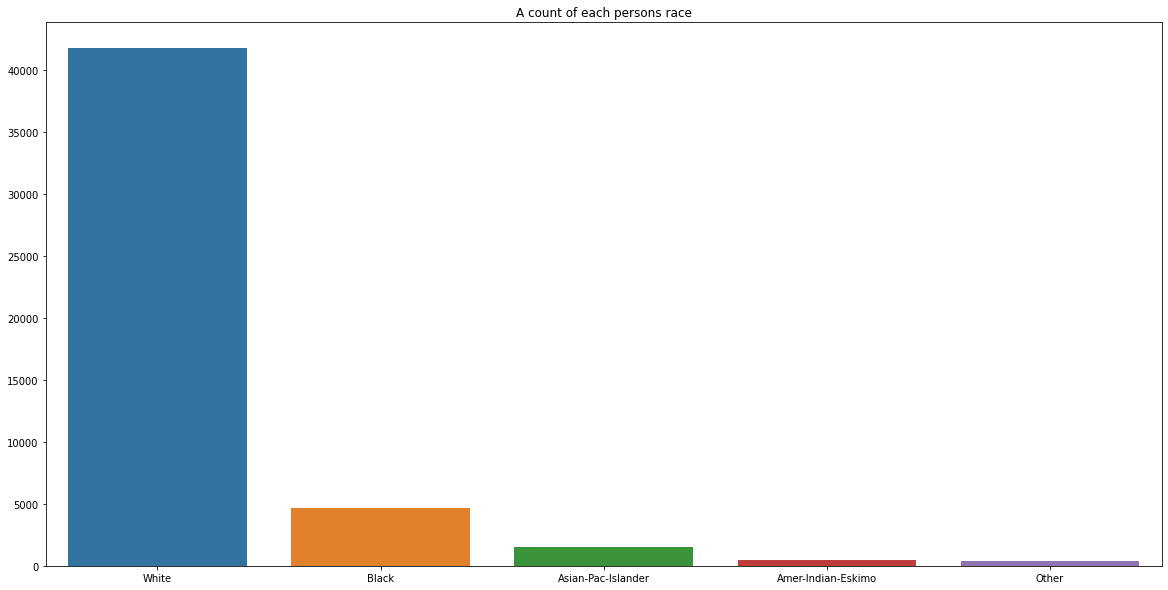

In [ ]:
race_count_df2['age'] = race_count_df2['age'].astype(int)
x = race_count_df2['race'].to_numpy()
y = race_count_df2['age'].to_numpy()
plt.figure(figsize=(20,10))
sns.barplot(x = x, y = y, data = race_count_df2).set(title="A count of each persons race")

Data set is skewed in this regard.

In [ ]:
pdf.head()

,age,workclass,final-weight,education,educationalnum,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,income,index,income_0_1
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,1,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,2,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,3,1
4,18,Unknown workClass,103497,Some-college,10,Never-married,Unknown Occupation,Own-child,White,Female,0,0,30,United-States,<=50K,4,0


In [ ]:
hoursperweek_count_df = pdf.groupby('hoursperweek').count().reset_index()
hoursperweek_count_df2 = hoursperweek_count_df[['hoursperweek', 'age']].sort_values(by='age', ascending=False).reset_index()
hoursperweek_count_df2

,index,hoursperweek,age
0,23,40,22803
1,60,50,4246
2,61,45,2717
3,76,60,2177
4,43,35,1937
5,24,20,1862
6,87,30,1700
7,44,55,1051
8,65,25,958
9,29,48,770


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


[Text(0.5, 1.0, 'Count of Hours Per Week')]

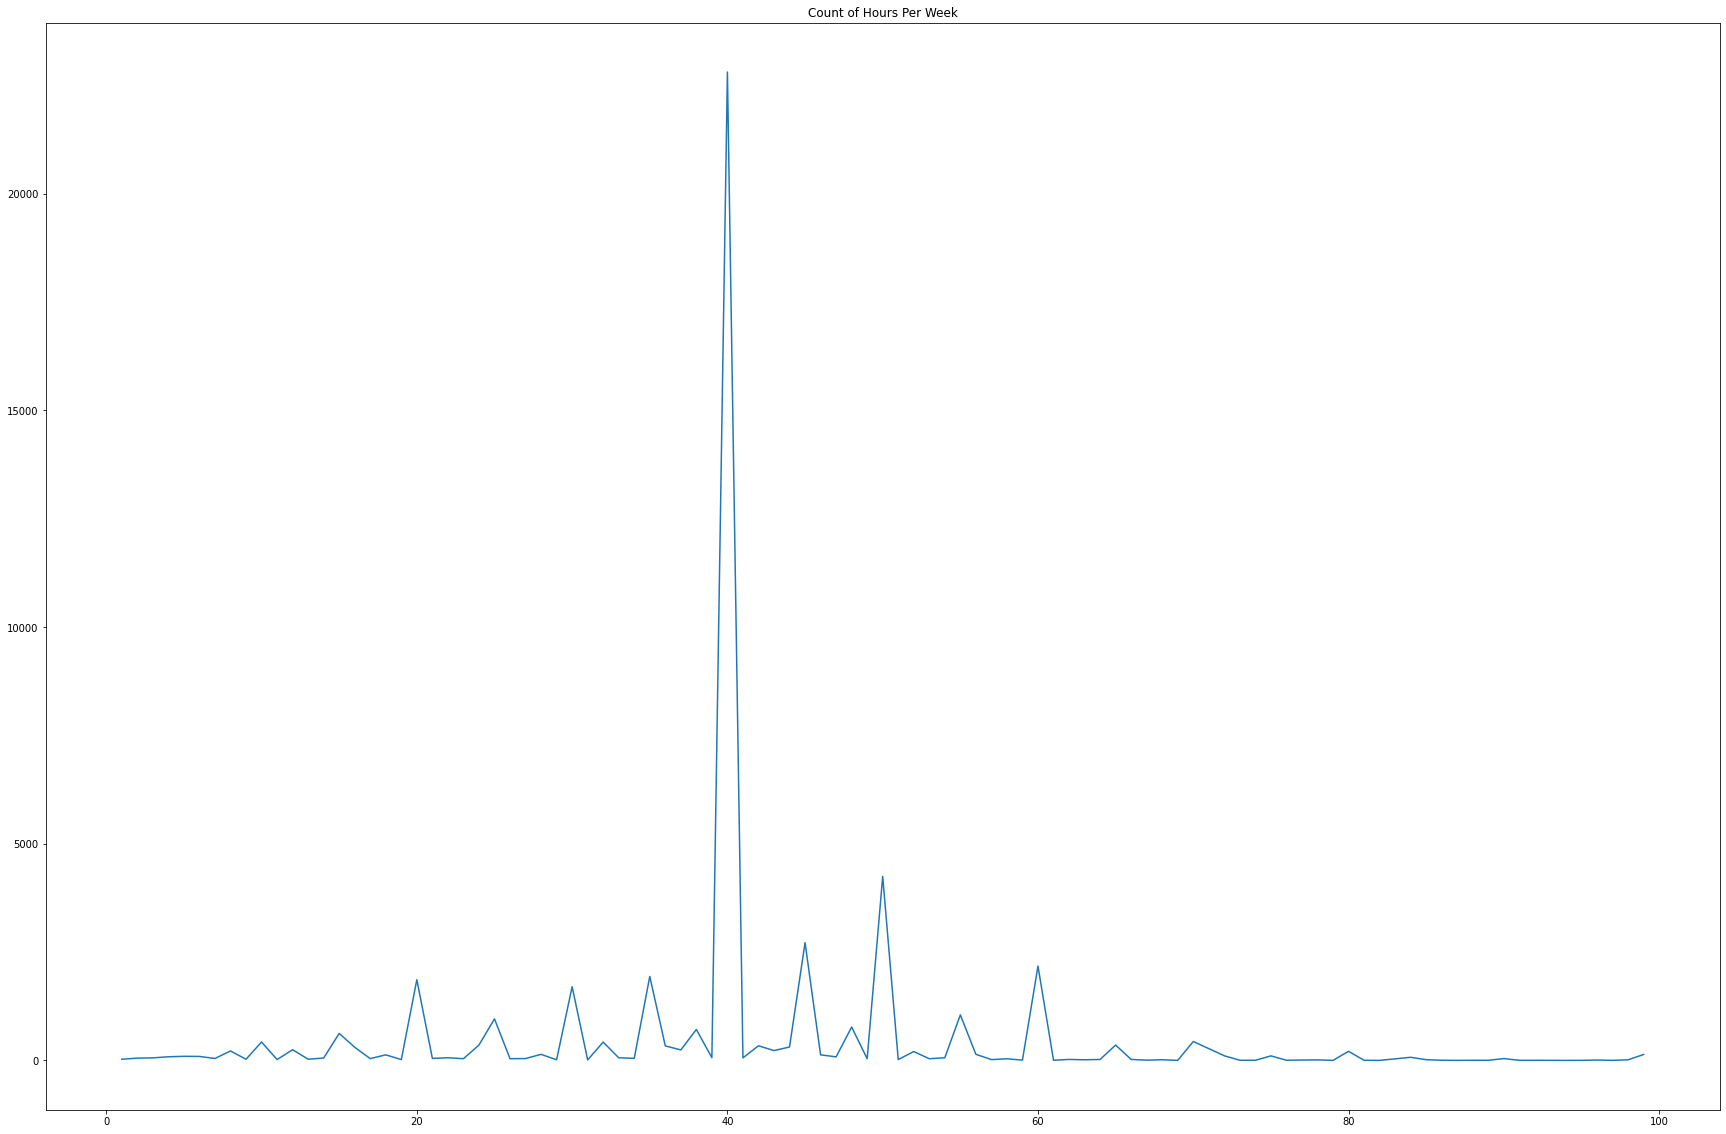

In [ ]:
hoursperweek_count_df2['age'] = hoursperweek_count_df2['age'].astype(int)
x = hoursperweek_count_df2['hoursperweek'].to_numpy()
y = hoursperweek_count_df2['age'].to_numpy()
plt.figure(figsize=(30,20))
sns.lineplot(x = x, y = y, data = hoursperweek_count_df2).set(title="Count of Hours Per Week")

A majority of of people work around 20, 40, or 60 hour weekly stints. Almost none 70 hours weekly or higher.

In [ ]:
#age is count
nativecountry_count_df = pdf.groupby('nativecountry').count().reset_index()
nativecountry_count_df2 = nativecountry_count_df[['nativecountry', 'age']].sort_values(by='age', ascending=False).reset_index()
nativecountry_count_df2

,index,nativecountry,age
0,28,United-States,43832
1,21,Mexico,951
2,29,Unknown Country,857
3,0,Philippines,295
4,1,Germany,206
5,25,Puerto-Rico,184
6,27,Canada,182
7,20,El-Salvador,155
8,10,India,151
9,14,Cuba,138


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/indexing.py:1362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


[Text(0.5, 1.0, 'Count of Whom live in each Country')]

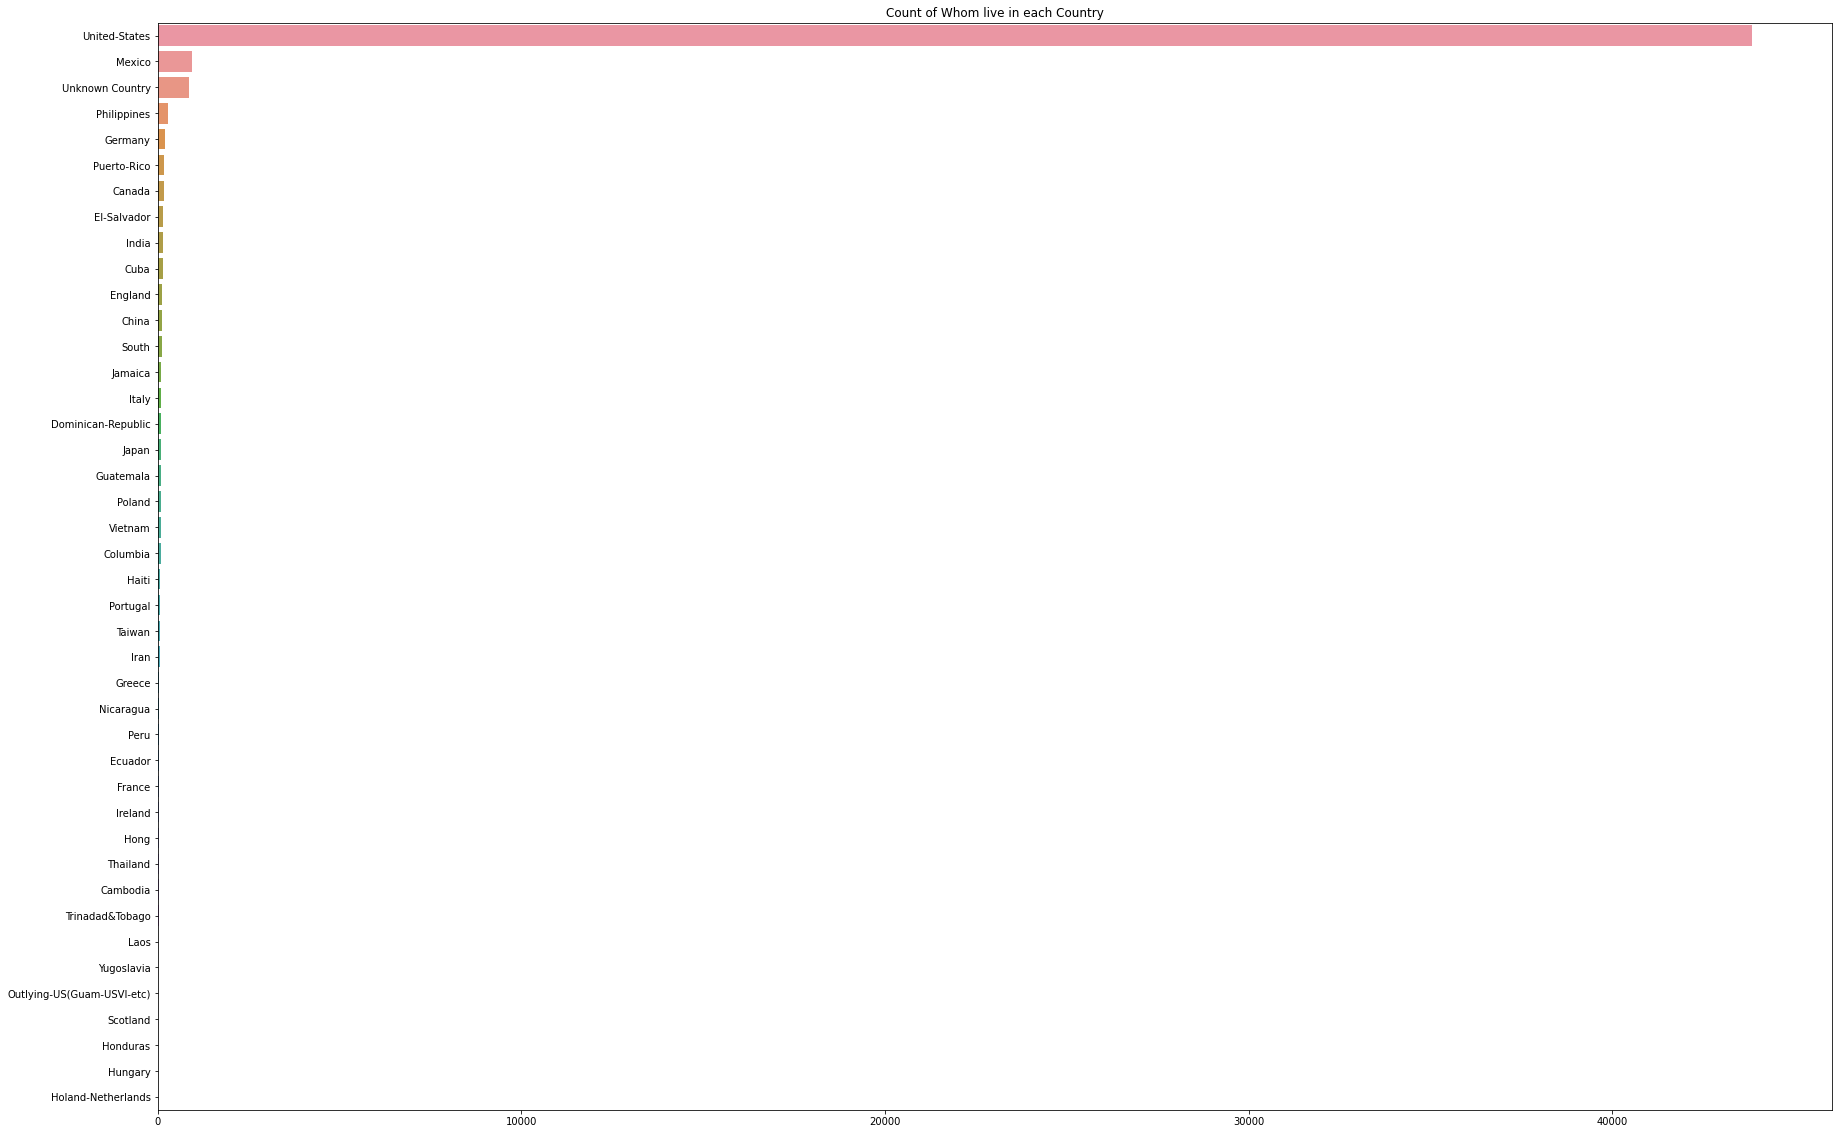

In [ ]:
nativecountry_count_df2['age'] = nativecountry_count_df2['age'].astype(int)
x = nativecountry_count_df2['nativecountry'].to_numpy()
y = nativecountry_count_df2['age'].to_numpy()
plt.figure(figsize=(30,20))
sns.barplot(x = y, y = x, data = nativecountry_count_df2).set(title="Count of Whom live in each Country")

This data is very skewed with United-States having	89.742435 of the people.

In [ ]:
nativecountry_count_df2['Percentage'] = nativecountry_count_df2['age'] * 100 / len(pdf)
nativecountry_count_df2

,index,nativecountry,age,Percentage
0,28,United-States,43832,89.742435
1,21,Mexico,951,1.947095
2,29,Unknown Country,857,1.754637
3,0,Philippines,295,0.603988
4,1,Germany,206,0.421768
5,25,Puerto-Rico,184,0.376725
6,27,Canada,182,0.372630
7,20,El-Salvador,155,0.317350
8,10,India,151,0.309160
9,14,Cuba,138,0.282544


3. What is the distribution of workclass column?
a. Use histogram for that

In [ ]:
#age is count
workclass_count_df = pdf.groupby('workclass').count().reset_index()
workclass_count_df2 = workclass_count_df[['workclass', 'age']].sort_values(by='age', ascending=False).reset_index()
workclass_count_df2

,index,workclass,age
0,3,Private,33906
1,0,Self-emp-not-inc,3862
2,1,Local-gov,3136
3,4,Unknown workClass,2799
4,2,State-gov,1981
5,8,Self-emp-inc,1695
6,6,Federal-gov,1432
7,5,Without-pay,21
8,7,Never-worked,10


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/indexing.py:1362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


[Text(0.5, 1.0, 'Count of Workclass')]

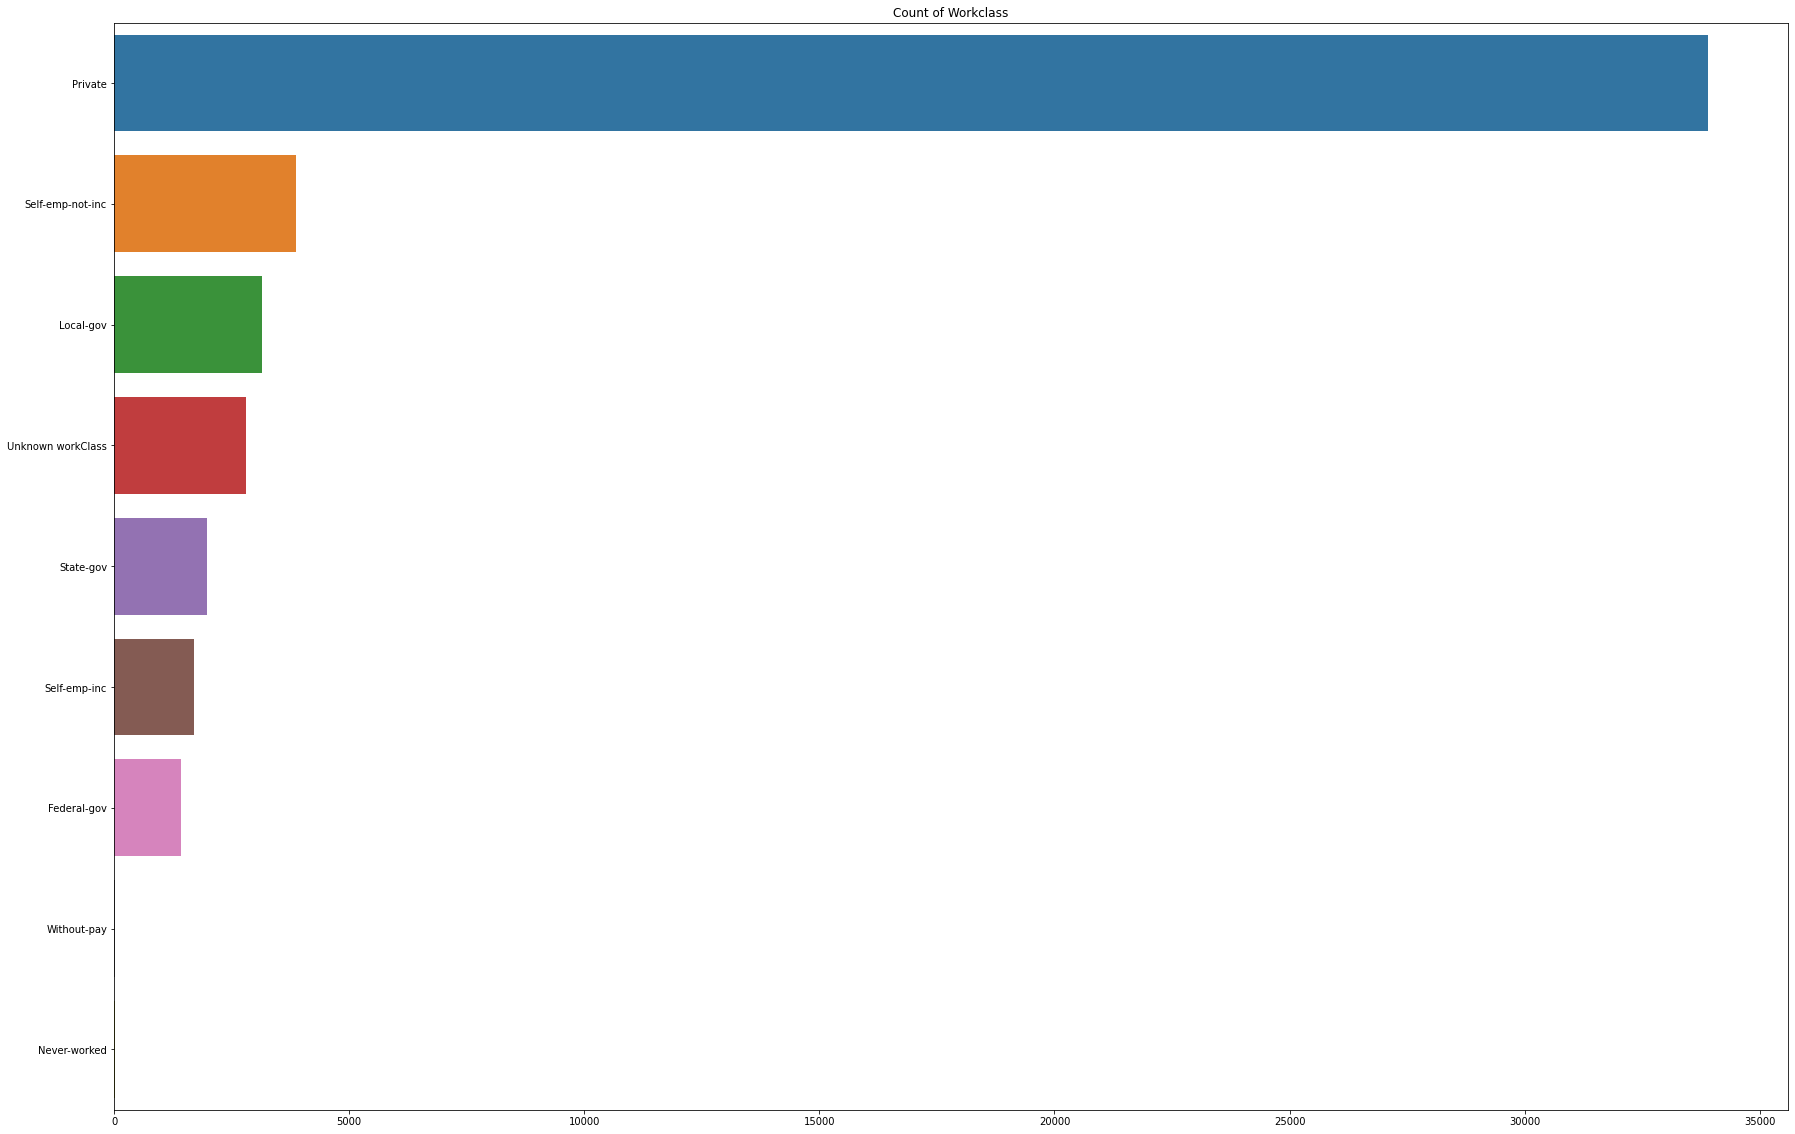

In [ ]:
workclass_count_df2['age'] = workclass_count_df2['age'].astype(int)
x = workclass_count_df2['workclass'].to_numpy()
y = workclass_count_df2['age'].to_numpy()
plt.figure(figsize=(30,20))
sns.barplot(x = y, y = x, data = workclass_count_df2).set(title="Count of Workclass")

                          Univariate analysis

1. What is the distribution of age column?

/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


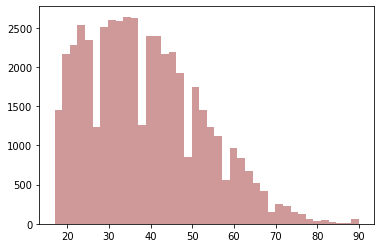

In [ ]:
sns.distplot(pdf['age'].to_numpy(),kde=False,color='darkred',bins=40)

2. Find total number of persons having age between 17 to 48 (inclusive) using
between method

In [ ]:
print('Total number of people between the age of 17 to 48: ', pdf['age'][pdf['age'].between(17, 48)].count())

Total number of people between the age of 17 to 48:  37321


In [ ]:
print('Percentage number of people between the age of 17 to 48: ', pdf['age'][pdf['age'].between(17, 48)].count() * 100 / len(pdf))

Percentage number of people between the age of 17 to 48:  76.41169485279063


In [ ]:
print('Total number of people between the age of 49 to 90: ', pdf['age'][pdf['age'].between(49, 90)].count())

Total number of people between the age of 49 to 90:  11521


In [ ]:
print('Percentage number of people between the age of 49 to 90: ', pdf['age'][pdf['age'].between(49, 90)].count() * 100 / len(pdf))

Percentage number of people between the age of 49 to 90:  23.58830514720937


    Bivariate analysis

1. Check relationship between ‘income ‘and ‘age’ column using boxplot.

In [ ]:
pdf.head(10)

,age,workclass,final-weight,education,educationalnum,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,income,index,income_0_1
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,1,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,2,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,3,1
4,18,Unknown workClass,103497,Some-college,10,Never-married,Unknown Occupation,Own-child,White,Female,0,0,30,United-States,<=50K,4,0
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K,5,0
6,29,Unknown workClass,227026,HS-grad,9,Never-married,Unknown Occupation,Unmarried,Black,Male,0,0,40,United-States,<=50K,6,0
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K,7,1
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K,8,0
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K,9,0


In [ ]:
#age is count
income01_count_df = pdf.groupby('income').count().reset_index()
income01_count_df2 = income01_count_df[['income', 'age']].sort_values(by='age', ascending=False).reset_index()
income01_count_df2

,index,income,age
0,0,<=50K,37155
1,1,>50K,11687


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/indexing.py:1362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


[Text(0.5, 1.0, 'Count of Income(Greater less than 50000)')]

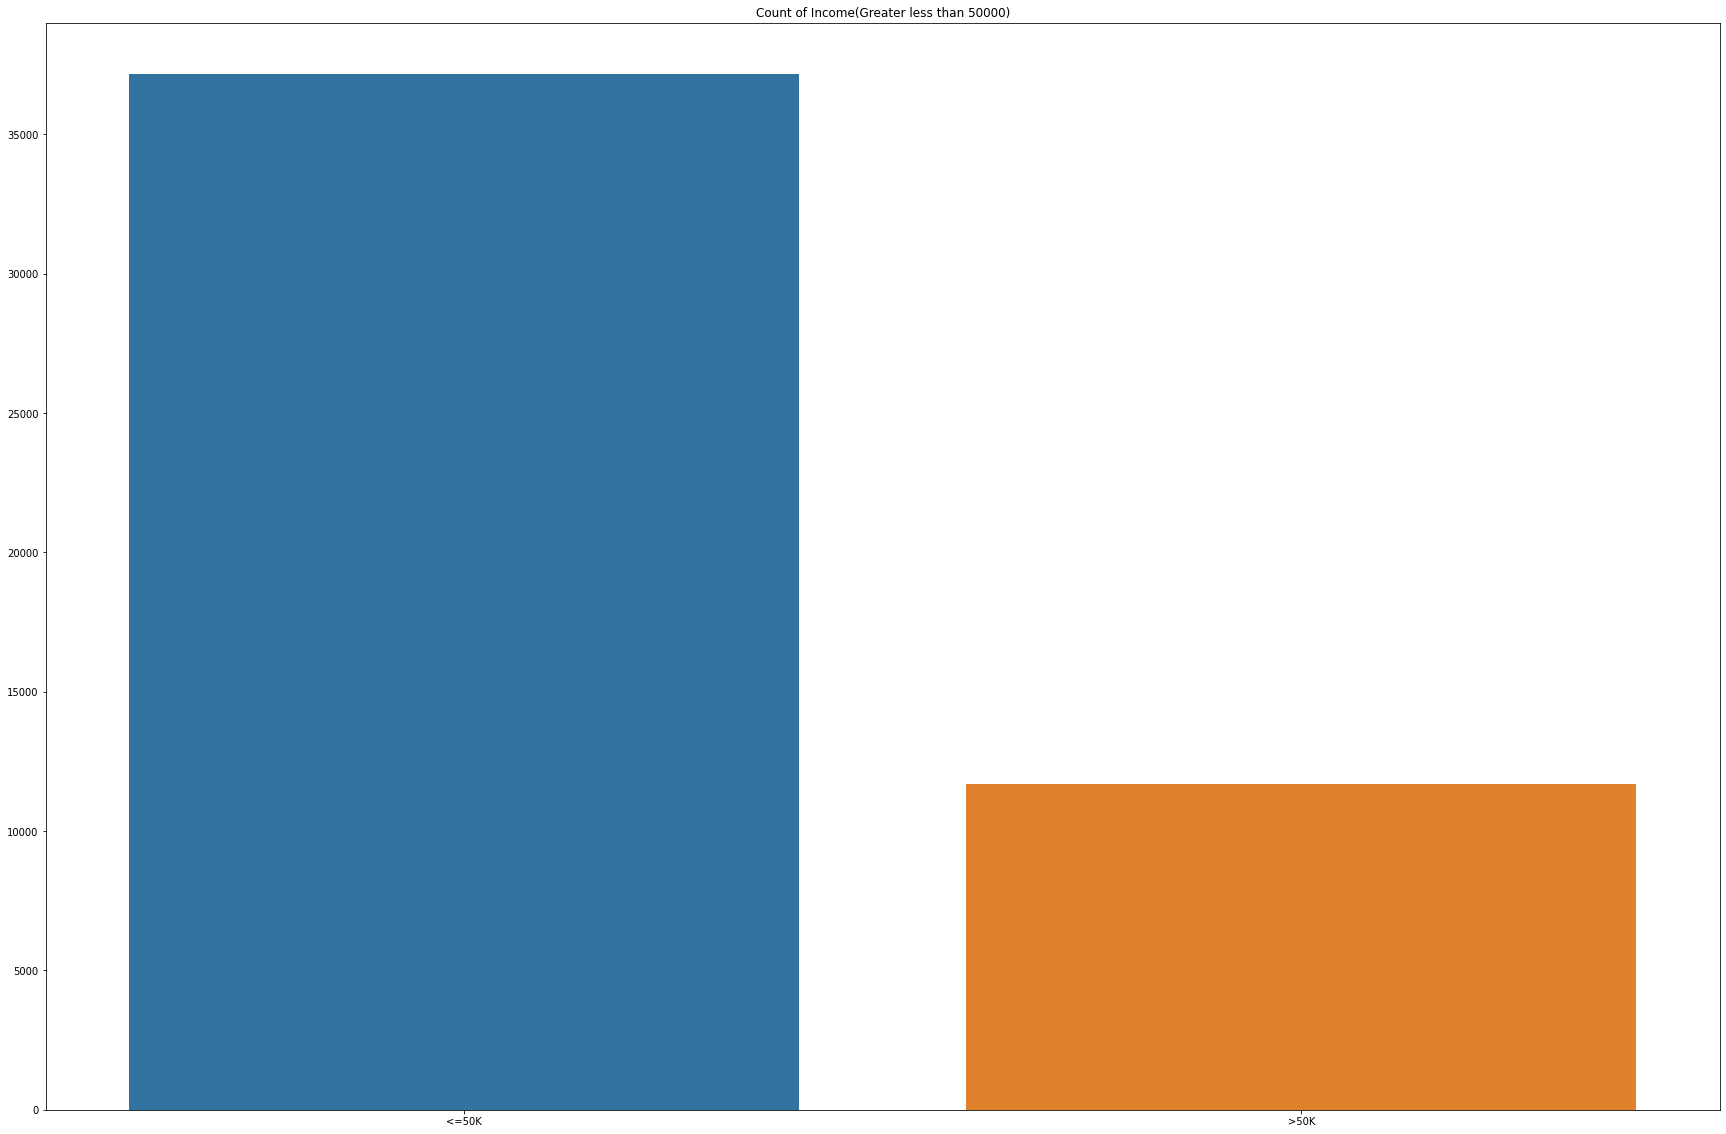

In [ ]:
income01_count_df2['age'] = income01_count_df2['age'].astype(int)
x = income01_count_df2['income'].to_numpy()
y = income01_count_df2['age'].to_numpy()
plt.figure(figsize=(30,20))
sns.barplot(x = x, y = y, data = income01_count_df2).set(title="Count of Income(Greater less than 50000)")

3. Which workclass getting the highest income?

In [ ]:
workclass_income = pdf.groupby(['workclass', 'income']).count().reset_index()
workclass_income2 = workclass_income[['workclass', 'income', 'age']].sort_values(by='age', ascending=False).reset_index()
workclass_income2

,index,workclass,income,age
0,0,Private,<=50K,26519
1,3,Private,>50K,7387
2,10,Self-emp-not-inc,<=50K,2785
3,11,Unknown workClass,<=50K,2534
4,16,Local-gov,<=50K,2209
5,12,State-gov,<=50K,1451
6,1,Self-emp-not-inc,>50K,1077
7,13,Self-emp-inc,>50K,938
8,15,Local-gov,>50K,927
9,7,Federal-gov,<=50K,871


4. How has better chance to get income greater than 50k male or female?

In [ ]:
male_female_income = pdf.groupby(['gender', 'income']).count().reset_index()
male_female_income2 = male_female_income[['gender', 'income', 'age']].sort_values(by='age', ascending=False).reset_index()
male_female_income2['Percentage'] = male_female_income2['age'] * 100 / len(pdf)
male_female_income2

,index,gender,income,age,Percentage
0,0,Male,<=50K,22732,46.541911
1,2,Female,<=50K,14423,29.529913
2,1,Male,>50K,9918,20.306294
3,3,Female,>50K,1769,3.621883


	Male made	>50K Total:	9918	percentage: 20.306294
	Female made	>50K   Total:	1769 percentage:	3.621883

  If these stats are right a whole 20 percent of men make >50k, compared to only 3% of women whom make the same.

Men in the United States have long earned more than women, on average, but this gender wage gap has slowly narrowed over time. The gap tends to be smaller among younger workers. - https://www.pewresearch.org/fact-tank/2022/03/28/young-women-are-out-earning-young-men-in-several-u-s-cities/

5. Convert workclass columns datatype to category datatype
a. Converting datatype can be useful in case of saving memory, you
need to optimize it.

In [ ]:
#pdf['workclass'] = pdf['workclass'].astype('category')
#pdf['workclass'].dtype

    Extras

In [ ]:
#write pdf to csv dataframe
pdf.to_csv("adult_cleaned2.csv")
df2 = spark.read.csv('/content/adult_cleaned2.csv', header=True, inferSchema=True)

/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


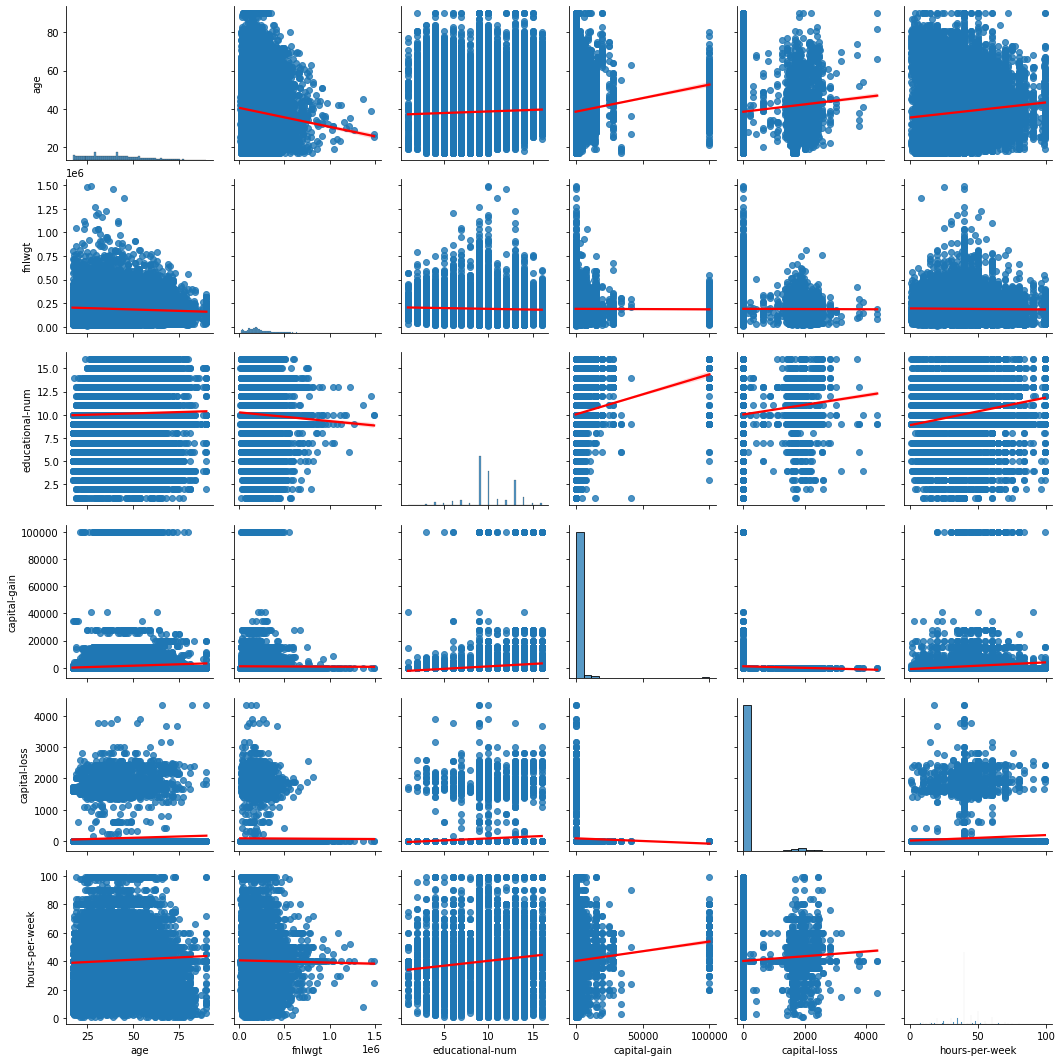

In [ ]:
#seaborn pair-plot with red linear regression line

sns.pairplot(df, kind="reg", palette="Set2", plot_kws={'line_kws':{'color':'red'}})
plt.show()

In [ ]:
#correlations between column values in cleaned pdf dataframe.
#A capital gains tax is the tax on profits realized on the sale of a non-inventory asset. The most common capital gains are realized from the sale of stocks, bonds, precious metals, real estate, and property.
pdf.corr()

,age,final-weight,educationalnum,capitalgain,capitalloss,hoursperweek,index,income_0_1
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558,-0.004967,0.230369
final-weight,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519,0.002579,-0.006339
educationalnum,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689,-0.004294,0.332613
capitalgain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157,-0.004300,0.223013
capitalloss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467,0.000864,0.147554
hoursperweek,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000,0.004985,0.227687
index,-0.004967,0.002579,-0.004294,-0.004300,0.000864,0.004985,1.000000,0.005234
income_0_1,0.230369,-0.006339,0.332613,0.223013,0.147554,0.227687,0.005234,1.000000


There seems to be a slight positive correlation between income(<> 50k column) and numberof education, age, and hoursperweek.